# Cross validation
Now we try various mooted techniques for cross validation to try and find some optimal rank of $V_n$, which we call $n^*$, for a given $m$. We construct $k$ subspaces or "slices" of $W_m$, where typically we remove some elements of the basis. We call $W^{(k)}_m$ the $k$-th subspace of $W_m$ with some basis elements removed. Note that $\langle u^*_k, \omega_i \rangle - \langle u, \omega_i\rangle = 0$ by definition of the method for any $\omega_i\in W^{(k)}_m$.

We calculate $u^*_k$, which is the optimal reconstruction for $W^{(k)}_m$ and $V_n$. Then we use an estimator
$$ 
\hat{\varepsilon}_{n,k}
:= \sum_{i=1}^m \left( \langle u^*_k, \omega_i \rangle - \langle u, \omega_i\rangle \right)^2 
=  \sum_{\omega_i \not\in W^{(k)}_{m}} \left( \langle u^*_k, \omega_i \rangle - \langle u, \omega_i\rangle \right)^2 
$$
Then $n^*_k = \arg \min_n \hat{\varepsilon}_{n,k}$, and we take $n^*$ to be the mean of the $n^*_k$.

I try a few different slice sizes in this notebook. First consider taking out larger slices, i.e take $K$ slices, for $1\le k \le K$ (and assume that $K$ divides $m$ evenly...), then remove $\omega_i$ from the basis for $kM < i \le (k+1)M$, i.e. we define $W_m^{(k)} = \mathrm{span}\{\omega_i\}_{i \,\not\in\, k M \ldots (k+1)M}$.

### First we compute our $u$ that we are approximating

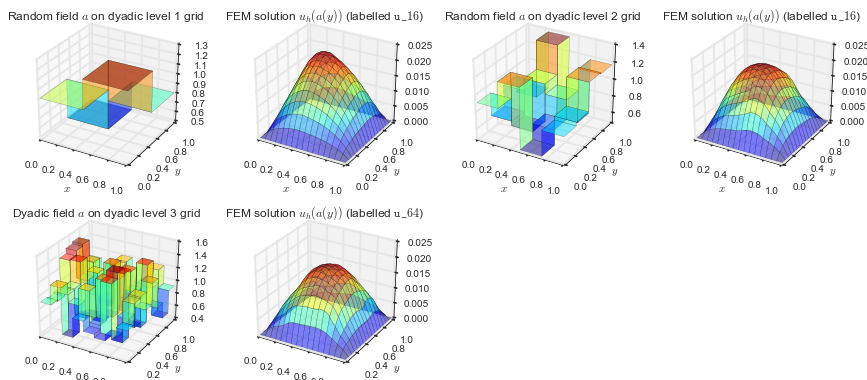

In [1]:
import numpy as np
import importlib
import dyadic_fem as df
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
importlib.reload(df)
%matplotlib inline

fem_div = 7

a_4 = df.make_dyadic_random_field(div=1, a_bar=1.0, c=0.5, seed=1)
fem_4 = df.DyadicFEMSolver(div=fem_div, rand_field=a_4, f=1.0)
fem_4.solve()

a_16 = df.make_dyadic_random_field(div=2, a_bar=1.0, c=0.5, seed=1)
fem_16 = df.DyadicFEMSolver(div=fem_div, rand_field=a_16, f=1.0)
fem_16.solve()

a_64 = df.make_dyadic_random_field(div=3, a_bar=1.0, c=0.5, seed=1)
fem_64 = df.DyadicFEMSolver(div=fem_div, rand_field=a_64, f=1.0)
fem_64.solve()

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(3, 4, 1, projection='3d')
a_4.plot(ax, title='Random field $a$ on dyadic level 1 grid')
ax = fig.add_subplot(3, 4, 2, projection='3d')
fem_4.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_16}$)')
ax = fig.add_subplot(3, 4, 3, projection='3d')
a_16.plot(ax, title='Random field $a$ on dyadic level 2 grid')
ax = fig.add_subplot(3, 4, 4, projection='3d')
fem_16.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_16}$)')
ax = fig.add_subplot(3, 4, 5, projection='3d')
a_64.plot(ax, title='Dyadic field $a$ on dyadic level 3 grid')
ax = fig.add_subplot(3, 4, 6, projection='3d')
fem_64.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_64}$)')
plt.show()

### We generate the ambient spaces $W_{\mathrm{big}}$ and $V_{\mathrm{big}}$ from which we pluck subspaces $W_m$ and $V_n$, as in the previous workbook ```6_nested_spaces``` 
In this case they are both of rank 150. Also in this case $V_n$ is generated from the 64-dimensional chess-board random fields, i.e. dyadic-level 3, as we are going to be looking at the solution ```fem_64.u```

In [2]:
# local_width is the width of the measurement squares
local_width = 2**(fem_div - 4)

ms = (25, 50, 100, 150)
m_big = ms[-1] # = 150

# We make the ambient spaces for Wm and Vn
Wbig = df.make_random_local_integration_basis(m=m_big, div=fem_div, width=local_width, space='H1')
Wbig = Wbig.orthonormalise()
Vbig, V_fields = df.make_reduced_basis(n=m_big, field_div=3, fem_div=fem_div, space='H1')
Vbig = Vbig.orthonormalise()

### First we do the computation for the full measurement space and a range of $n$, and save the results... 

In [80]:
from numpy import s_

m = 120

mask = np.ones(ms[-1], dtype=np.bool)
mask[m:] = False
Wm = Wbig.subspace_mask(mask)

w = Wm.dot(fem_64.u)
u_p_w = Wm.project(fem_64.u)

full_ns = range(2, Wm.n, 2)
full_stats = np.zeros([6, len(full_ns)])

for i, n in enumerate(full_ns):

    Vn = Vbig.subspace(slice(0,n))
    u_p_v = Vn.project(fem_64.u)

    BP = df.BasisPair(Wm, Vn)
    FB = BP.make_favorable_basis()

    u_star, v_star, w_p, v_w_p = FB.measure_and_reconstruct(fem_64.u)

    true_eps = (fem_64.u-u_star).norm(space='H1')
    
    full_stats[0, i] = true_eps
    full_stats[1, i] = 0.0
    full_stats[2, i] = (u_star - v_star).norm(space='H1')
    full_stats[3, i] = FB.beta()
    full_stats[4, i] = np.linalg.cond(BP.G.T @ BP.G)
    full_stats[5, i] = (fem_64.u - u_p_v).norm(space='H1')

### Now we compute the stats for $K=5$ slices

In [81]:
K = 5
slice_size = int(m / K)

K_stats = np.zeros(K)

slice_ns = range(2, m - slice_size, 2)
slice_stats = np.zeros([6, K, len(slice_ns)])

print('Computing slice', end='')

for k in range(K):
    print(' {0}...'.format(k), end='')
    mask = np.ones(m, dtype=np.bool)
    mask[k * slice_size: (k+1) * slice_size] = False
    Wslice = Wm.subspace_mask(mask)

    # This is the measurement vector
    w_s = Wslice.dot(fem_64.u)
    u_p_w_s = Wslice.project(fem_64.u)

    K_stats[k] = (fem_64.u-u_p_w_s).norm(space='H1')

    for i, n in enumerate(slice_ns):
    
        Vn = Vbig.subspace(slice(0,n))
        u_p_v = Vn.project(fem_64.u)
        
        BP = df.BasisPair(Wslice, Vn)
        FB = BP.make_favorable_basis()
        
        u_star, v_star, w_p, v_w_p = FB.measure_and_reconstruct(fem_64.u)
        
        resid = w - Wm.dot(u_star)
        eps = (resid * resid).sum()
        true_eps = (fem_64.u-u_star).norm(space='H1')
        
        slice_stats[0, k, i] = true_eps
        slice_stats[1, k, i] = eps
        slice_stats[2, k, i] = (u_star - v_star).norm(space='H1')
        slice_stats[3, k, i] = FB.beta()
        slice_stats[4, k, i] = np.linalg.cond(BP.G.T @ BP.G)
        slice_stats[5, k, i] = (fem_64.u - u_p_v).norm(space='H1')

Computing slice 0... 1... 2... 3... 4...

...And look at and plot the results

n* for each of the K slices: [72, 90, 64, 74, 90]

eps* for each of the K slices: [9.5934e-06, 2.643e-06, 2.4802e-06, 3.4473e-06, 9.4129e-07]

So avg n* = 78 for which || u - u* || = 1.3079881437139863e-05

arg min and min over all Vn of || u - u* || with full measurement space Wm: 68 1.1780357306218879e-05


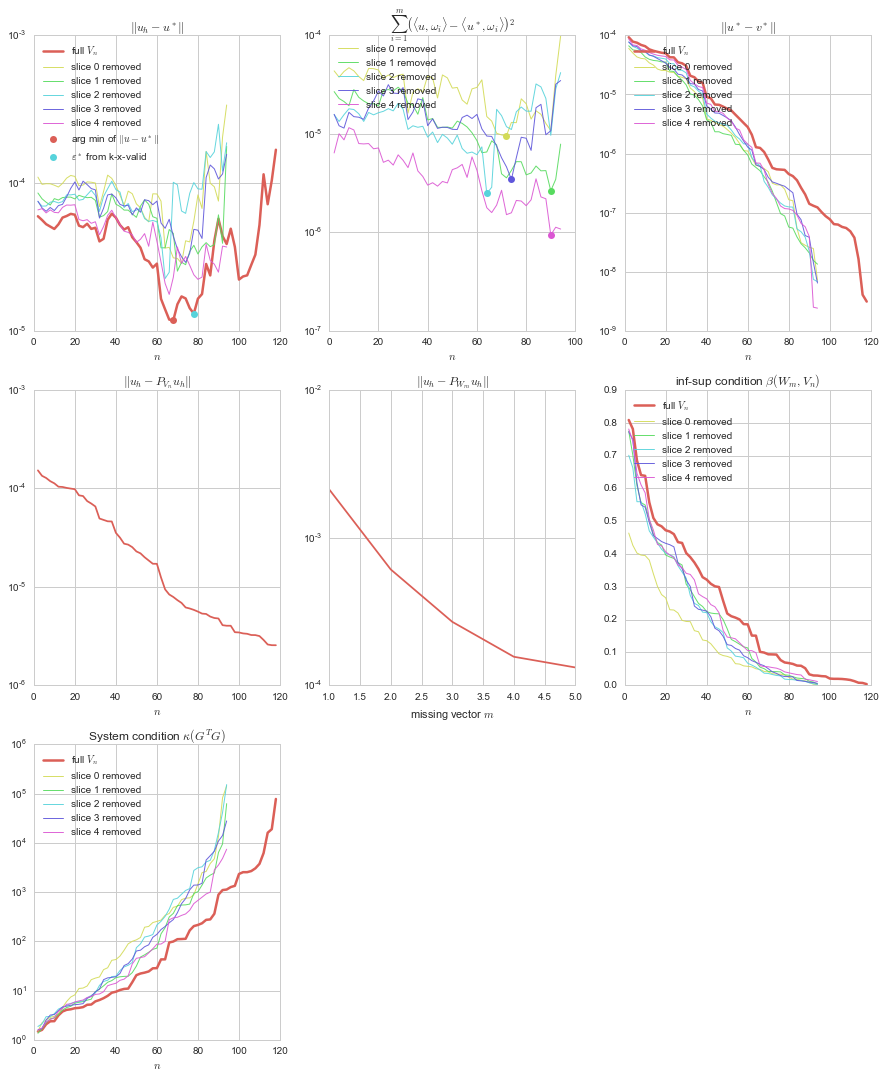

In [95]:
# Now, slice_stats[1, k, :] contains epsilon^* that we want
loc_star_k = np.argmin(slice_stats[1,:,:], axis=1)
n_star_k = [slice_ns[loc] for loc in loc_star_k]
eps_star_k = [slice_stats[1,k,loc_star_k[k]] for k in range(K)]

loc_min = np.argmin(full_stats[0,:])
n_min = full_ns[loc_min]
eps_min = full_stats[0,loc_min]

n_star = int(round(np.mean(n_star_k)))
eps_star = full_stats[0, np.abs(np.array(full_ns) - n_star).argmin()]

print('n* for each of the K slices: ', end='')
print(n_star_k)
print('\neps* for each of the K slices: ', end='')
print([float('{0:0.4e}'.format(e)) for e in eps_star_k])
print('\nSo avg n* = {0} for which || u - u* || = {1}'.format(n_star, eps_star))
print('\narg min and min over all Vn of || u - u* || with full measurement space Wm: {0} {1}'.format(n_min, eps_min))

cp = sns.color_palette("hls", K+1)
sns.set_style("whitegrid")

axs = []
fig = plt.figure(figsize=(15, 18))
axs.append(fig.add_subplot(3, 3, 1, title=r'$\| u_h - u^* \|$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 3, 2, title=r'$\sum_{i=1}^m \left( \langle u, \omega_i \rangle - \langle u^*, \omega_i\rangle \right)^2$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 3, 3, title=r'$\| u^* - v^* \|$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 3, 4, title=r'$\| u_h - P_{V_n} u_h \|$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 3, 5, title=r'$\| u_h - P_{W_m} u_h \|$'))
axs[-1].set(yscale="log", xlabel='missing vector $m$')
axs.append(fig.add_subplot(3, 3, 6, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(xlabel='$n$')
axs.append(fig.add_subplot(3, 3, 7, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')


axs[0].plot(full_ns, full_stats[0,:], label='full $V_n$', color=cp[0], lw=2.5)
axs[0].legend(loc=2)
#axs[1].plot(full_ns, full_stats[1,:], label='full $V_n$')
#axs[1].legend(loc=
axs[2].plot(full_ns, full_stats[2,:], label='full $V_n$', color=cp[0], lw=2.5)
axs[2].legend(loc=2)
axs[5].plot(full_ns, full_stats[3,:], label='full $V_n$', color=cp[0], lw=2.5)
axs[5].legend(loc=2)
axs[6].plot(full_ns, full_stats[4,:], label='full $V_n$', color=cp[0], lw=2.5)
axs[6].legend(loc=2)

axs[3].plot(full_ns, full_stats[5,:], color=cp[0])
axs[4].plot(range(1, K+1), K_stats[:], label='m={0}'.format(m), color=cp[0])

#sns.set_palette("GnBu_d", K)

for k in range(K):

    axs[0].plot(slice_ns, slice_stats[0, k, :], label='slice {0} removed'.format(k), color=cp[k+1], alpha=0.9, lw=1)
    axs[0].legend(loc=2)
    axs[1].plot(slice_ns, slice_stats[1, k, :], label='slice {0} removed'.format(k), color=cp[k+1], alpha=0.9, lw=1)
    axs[1].plot(n_star_k[k], eps_star_k[k], color=cp[k+1], marker='o')
    axs[1].legend(loc=2)
    axs[2].plot(slice_ns, slice_stats[2, k, :], label='slice {0} removed'.format(k), color=cp[k+1], alpha=0.9, lw=1)
    axs[2].legend(loc=2)
    axs[5].plot(slice_ns, slice_stats[3, k, :], label='slice {0} removed'.format(k), color=cp[k+1], alpha=0.9, lw=1)
    axs[5].legend(loc=2)
    axs[6].plot(slice_ns, slice_stats[4, k, :], label='slice {0} removed'.format(k), color=cp[k+1], alpha=0.9, lw=1)
    axs[6].legend(loc=2)

axs[0].plot(n_min, eps_min, label='arg min of $\|u - u^* \|$', color=cp[0], marker='o', lw=2.5, linestyle="None")
axs[0].plot(n_star, eps_star, label=r'$\varepsilon^*$ from k-x-valid', color=cp[3], marker='o', lw=2.5, linestyle="None")
axs[0].legend(loc=2, numpoints=1)

plt.show()

### Here we try $K=10$ slices with $m=150$, so a much longer computation!

In [97]:
from numpy import s_

m = 150

mask = np.ones(ms[-1], dtype=np.bool)
mask[m:] = False
Wm = Wbig.subspace_mask(mask)

w = Wm.dot(fem_64.u)
u_p_w = Wm.project(fem_64.u)

full_ns = range(2, Wm.n, 2)
full_stats = np.zeros([6, len(full_ns)])

for i, n in enumerate(full_ns):

    Vn = Vbig.subspace(slice(0,n))
    u_p_v = Vn.project(fem_64.u)

    BP = df.BasisPair(Wm, Vn)
    FB = BP.make_favorable_basis()

    u_star, v_star, w_p, v_w_p = FB.measure_and_reconstruct(fem_64.u)

    true_eps = (fem_64.u-u_star).norm(space='H1')
    
    full_stats[0, i] = true_eps
    full_stats[1, i] = 0.0
    full_stats[2, i] = (u_star - v_star).norm(space='H1')
    full_stats[3, i] = FB.beta()
    full_stats[4, i] = np.linalg.cond(BP.G.T @ BP.G)
    full_stats[5, i] = (fem_64.u - u_p_v).norm(space='H1')

In [98]:
K = 10
slice_size = int(m / K)

K_stats = np.zeros(K)

slice_ns = range(2, m - slice_size, 2)
slice_stats = np.zeros([6, K, len(slice_ns)])

print('Computing slice', end='')

for k in range(K):
    print(' {0}...'.format(k), end='')
    mask = np.ones(m, dtype=np.bool)
    mask[k * slice_size: (k+1) * slice_size] = False
    Wslice = Wm.subspace_mask(mask)

    # This is the measurement vector
    w_s = Wslice.dot(fem_64.u)
    u_p_w_s = Wslice.project(fem_64.u)

    K_stats[k] = (fem_64.u-u_p_w_s).norm(space='H1')

    for i, n in enumerate(slice_ns):
    
        Vn = Vbig.subspace(slice(0,n))
        u_p_v = Vn.project(fem_64.u)
        
        BP = df.BasisPair(Wslice, Vn)
        FB = BP.make_favorable_basis()
        
        u_star, v_star, w_p, v_w_p = FB.measure_and_reconstruct(fem_64.u)
        
        resid = w - Wm.dot(u_star)
        eps = (resid * resid).sum()
        true_eps = (fem_64.u-u_star).norm(space='H1')
        
        slice_stats[0, k, i] = true_eps
        slice_stats[1, k, i] = eps
        slice_stats[2, k, i] = (u_star - v_star).norm(space='H1')
        slice_stats[3, k, i] = FB.beta()
        slice_stats[4, k, i] = np.linalg.cond(BP.G.T @ BP.G)
        slice_stats[5, k, i] = (fem_64.u - u_p_v).norm(space='H1')

Computing slice 0... 1... 2... 3... 4... 5... 6... 7... 8... 9...

n* for each of the K slices: [64, 94, 70, 94, 72, 78, 100, 102, 126, 76]

eps* for each of the K slices: [2.2137e-06, 5.8576e-07, 6.001e-07, 3.3269e-07, 7.1009e-07, 1.6308e-07, 3.2084e-07, 2.3207e-07, 3.414e-07, 3.1382e-07]

So avg n* = 88 for which || u - u* || = 1.3300009374309327e-05

arg min and min over all Vn of || u - u* || with full measurement space Wm: 100 8.094335824737036e-06


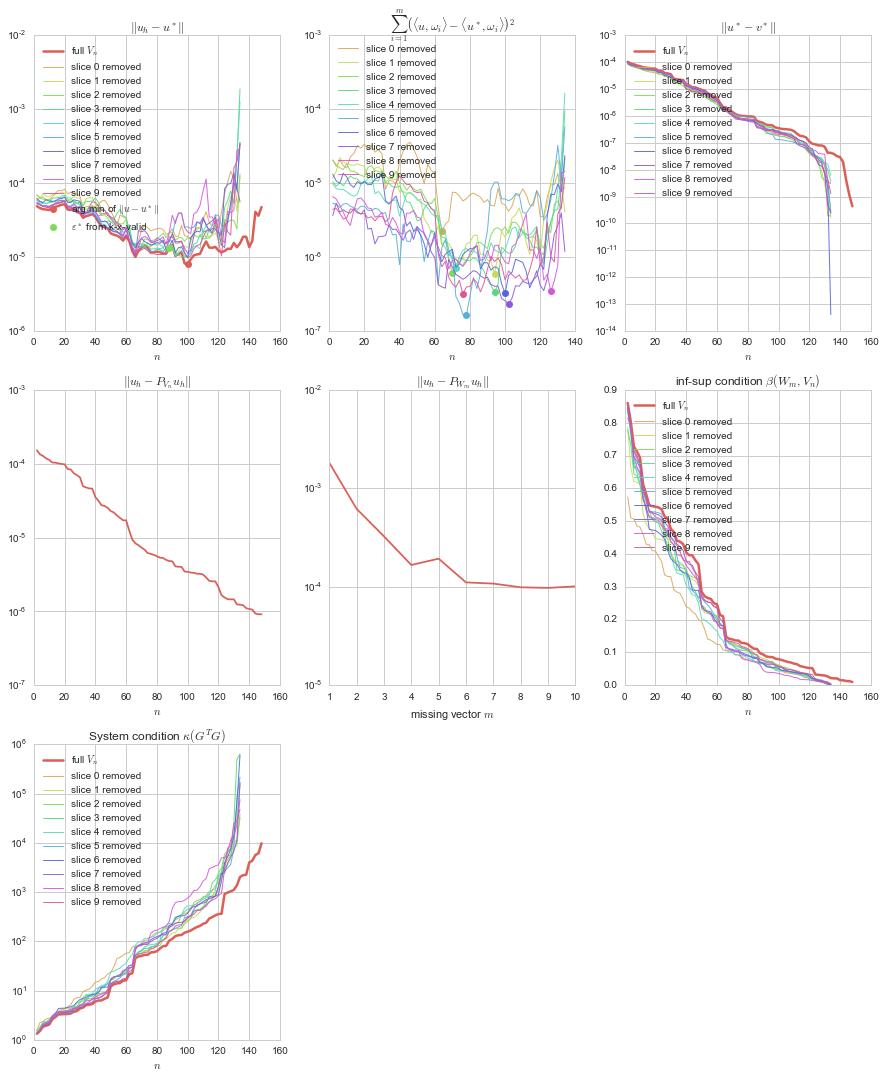

In [99]:

# Now, slice_stats[1, k, :] contains epsilon^* that we want
loc_star_k = np.argmin(slice_stats[1,:,:], axis=1)
n_star_k = [slice_ns[loc] for loc in loc_star_k]
eps_star_k = [slice_stats[1,k,loc_star_k[k]] for k in range(K)]

loc_min = np.argmin(full_stats[0,:])
n_min = full_ns[loc_min]
eps_min = full_stats[0,loc_min]

n_star = int(round(np.mean(n_star_k)))
eps_star = full_stats[0, np.abs(np.array(full_ns) - n_star).argmin()]

print('n* for each of the K slices: ', end='')
print(n_star_k)
print('\neps* for each of the K slices: ', end='')
print([float('{0:0.4e}'.format(e)) for e in eps_star_k])
print('\nSo avg n* = {0} for which || u - u* || = {1}'.format(n_star, eps_star))
print('\narg min and min over all Vn of || u - u* || with full measurement space Wm: {0} {1}'.format(n_min, eps_min))

cp = sns.color_palette("hls", K+1)
sns.set_style("whitegrid")

axs = []
fig = plt.figure(figsize=(15, 18))
axs.append(fig.add_subplot(3, 3, 1, title=r'$\| u_h - u^* \|$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 3, 2, title=r'$\sum_{i=1}^m \left( \langle u, \omega_i \rangle - \langle u^*, \omega_i\rangle \right)^2$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 3, 3, title=r'$\| u^* - v^* \|$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 3, 4, title=r'$\| u_h - P_{V_n} u_h \|$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 3, 5, title=r'$\| u_h - P_{W_m} u_h \|$'))
axs[-1].set(yscale="log", xlabel='missing vector $m$')
axs.append(fig.add_subplot(3, 3, 6, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(xlabel='$n$')
axs.append(fig.add_subplot(3, 3, 7, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')


axs[0].plot(full_ns, full_stats[0,:], label='full $V_n$', color=cp[0], lw=2.5)
axs[0].legend(loc=2)
#axs[1].plot(full_ns, full_stats[1,:], label='full $V_n$')
#axs[1].legend(loc=
axs[2].plot(full_ns, full_stats[2,:], label='full $V_n$', color=cp[0], lw=2.5)
axs[2].legend(loc=2)
axs[5].plot(full_ns, full_stats[3,:], label='full $V_n$', color=cp[0], lw=2.5)
axs[5].legend(loc=2)
axs[6].plot(full_ns, full_stats[4,:], label='full $V_n$', color=cp[0], lw=2.5)
axs[6].legend(loc=2)

axs[3].plot(full_ns, full_stats[5,:], color=cp[0])
axs[4].plot(range(1, K+1), K_stats[:], label='m={0}'.format(m), color=cp[0])

#sns.set_palette("GnBu_d", K)

for k in range(K):

    axs[0].plot(slice_ns, slice_stats[0, k, :], label='slice {0} removed'.format(k), color=cp[k+1], alpha=0.9, lw=1)
    axs[0].legend(loc=2)
    axs[1].plot(slice_ns, slice_stats[1, k, :], label='slice {0} removed'.format(k), color=cp[k+1], alpha=0.9, lw=1)
    axs[1].plot(n_star_k[k], eps_star_k[k], color=cp[k+1], marker='o')
    axs[1].legend(loc=2)
    axs[2].plot(slice_ns, slice_stats[2, k, :], label='slice {0} removed'.format(k), color=cp[k+1], alpha=0.9, lw=1)
    axs[2].legend(loc=2)
    axs[5].plot(slice_ns, slice_stats[3, k, :], label='slice {0} removed'.format(k), color=cp[k+1], alpha=0.9, lw=1)
    axs[5].legend(loc=2)
    axs[6].plot(slice_ns, slice_stats[4, k, :], label='slice {0} removed'.format(k), color=cp[k+1], alpha=0.9, lw=1)
    axs[6].legend(loc=2)

axs[0].plot(n_min, eps_min, label='arg min of $\|u - u^* \|$', color=cp[0], marker='o', lw=2.5, linestyle="None")
axs[0].plot(n_star, eps_star, label=r'$\varepsilon^*$ from k-x-valid', color=cp[3], marker='o', lw=2.5, linestyle="None")
axs[0].legend(loc=2, numpoints=1)

plt.show()